<img src="neid_thin.png" width="600"></img>

<h1><center>NEID Data Analysis Tutorial: Part 2 </center></h1>

<center><b>Author</b>: Arpita Roy (aroy@stsci.edu) | <b>Latest update</b>: June 15, 2021.</center>

--------------------------------------------------------------


## Table of contents
1. [Introduction](#intro)
2. [Open FITS File](#fits)
3. [Continuum Normalization](#fitcont)



### 1. Introduction <a class="anchor" id="intro"></a>
[NEID](https://neid.psu.edu/) is an extreme precision, high resolution [echelle](https://en.wikipedia.org/wiki/Echelle_grating) spectrograph that is designed for exoplanet discovery and characterization. This is a beginner's guide to NEID data analysis. In this tutorial, we will learn to look at continuum normalize NEID data, and do some basic peak finding to locate absorption lines. 

This kind of pre-processing is necessary for scrutinizing line behaviors, particularly for research projects related to stellar activity monitoring. 

Let's start by importing all the libraries we will need.

In [161]:
# Import file handling libraries:
import os
from glob import glob

# Import numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy for fits handling:
from astropy.io import fits

# Echelle spectra handling libraries
from pyreduce import continuum_normalization
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline

In [5]:
# You can set your plotting style of choice here
plt.style.use(['seaborn-darkgrid'])

### 2. Open FITS File <a class="anchor" id="fits"></a>
We have a sample observation of the Sun to look at. Let's open up the FITS file and explore its contents. Note the NEID file naming convention: neidL#_YYYYMMDDThhmmss.fits, where # is 0, 1, or 2 for the data level, and YYYYMMDDThhmmss is the timestamp corresponding to the beginning of the exposure. So this observation was taken on 8th February 2021, a little after 7pm UT.

In [6]:
hdul = fits.open('neidL2_20210208T191024.fits')

FITS files contain both data and metadata (information about the data). For NEID, the L2 FITS file is data cube containing several extensions with data, and corresponding headers with metadata about the observation conditions and processing that has already been performed. You can get a quick view of what is in the FITS file like this:

In [7]:
hdul.info()

Filename: neidL2_20210208T191024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     740   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2253   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      
 12  CCFS          1 ImageHDU       515   (804, 122)   float64   
 13  ACTIVITY      1 BinTableHDU     41   15R x 12C   [10A, D,

The names of the extensions should give you a good idea of what data is contained in them. The most important ones, as you are getting started are:
- `SCIFLUX` contains the flux from the science target (typically a star, in this case, the Sun)
- `SCIWAVE` contains the corresponding wavelength values per pixel in the spectrum

Let's see what those arrays look like.

In [8]:
flux = hdul['SCIFLUX'].data
wave = hdul['SCIWAVE'].data

print(flux.shape)
print(wave.shape)

(122, 9216)
(122, 9216)


These are both arrays with the same dimensions. They have 122 spectral orders, each with 9216 pixels across the large NEID CCD.

### 3. Continuum Normalization <a class="anchor" id="fitcont"></a>

There are many ways to do continuum normalization, each with pros and cons. We will try a few different methods here. To begin with, let's use just one order.

In [40]:
order = 50
pix_array = np.arange(flux.shape[1])

In [255]:
# Set NaNs to zero
flux[np.isnan(flux)] = 0
wave[np.isnan(wave)] = 0

### a) Fit a Polynomial
Perhaps the simplest way to try and remove the blaze function is to use a polynomial. Let's write a function to fit the spectrum with a polynomial in chunks.

In [256]:
def chunked_continuum_fit(x, y, percentile_cut=95.0, nchunks=15, deg=5):
    chunks_x = np.zeros(nchunks) #Chunk up spectrum and store mini-spectrum chunks in lists
    chunks_y = np.zeros(nchunks)
    npixels = len(x)
    pixels_per_chunk = npixels / nchunks
    for i in range(nchunks): #Loop through each chunk
        chunk_i1 = np.int(i*pixels_per_chunk)
        chunk_i2 = np.int((i+1)*pixels_per_chunk)
        if chunk_i2 > npixels: #Chop end of last chunk
            chunk_i2 = npixels
        chunks_y[i] = np.nanpercentile(y[chunk_i1:chunk_i2], percentile_cut) #Chunk y is xxth percentile of chunk
        chunks_x[i] = 0.5*(x[chunk_i1:chunk_i2][0]+x[chunk_i1:chunk_i2][-1]) #Chunk x is just center of chunk
    smooth_y = savgol_filter(chunks_y, 11, 1) # add some smoothin to avoid "falling" into lines
    pfit = np.polyfit(chunks_x, smooth_y, deg=deg) #fit polynomial to chunks
    cs = CubicSpline(chunks_x, chunks_y)
    return np.polyval(pfit, x), cs, chunks_x, chunks_y #Return continuum array generated from polynomial fit

In [257]:
chunkfit, cs,chunks_x, chunks_y = chunked_continuum_fit(pix_array,flux[order,:],percentile_cut=90.0, nchunks=100, deg=7)


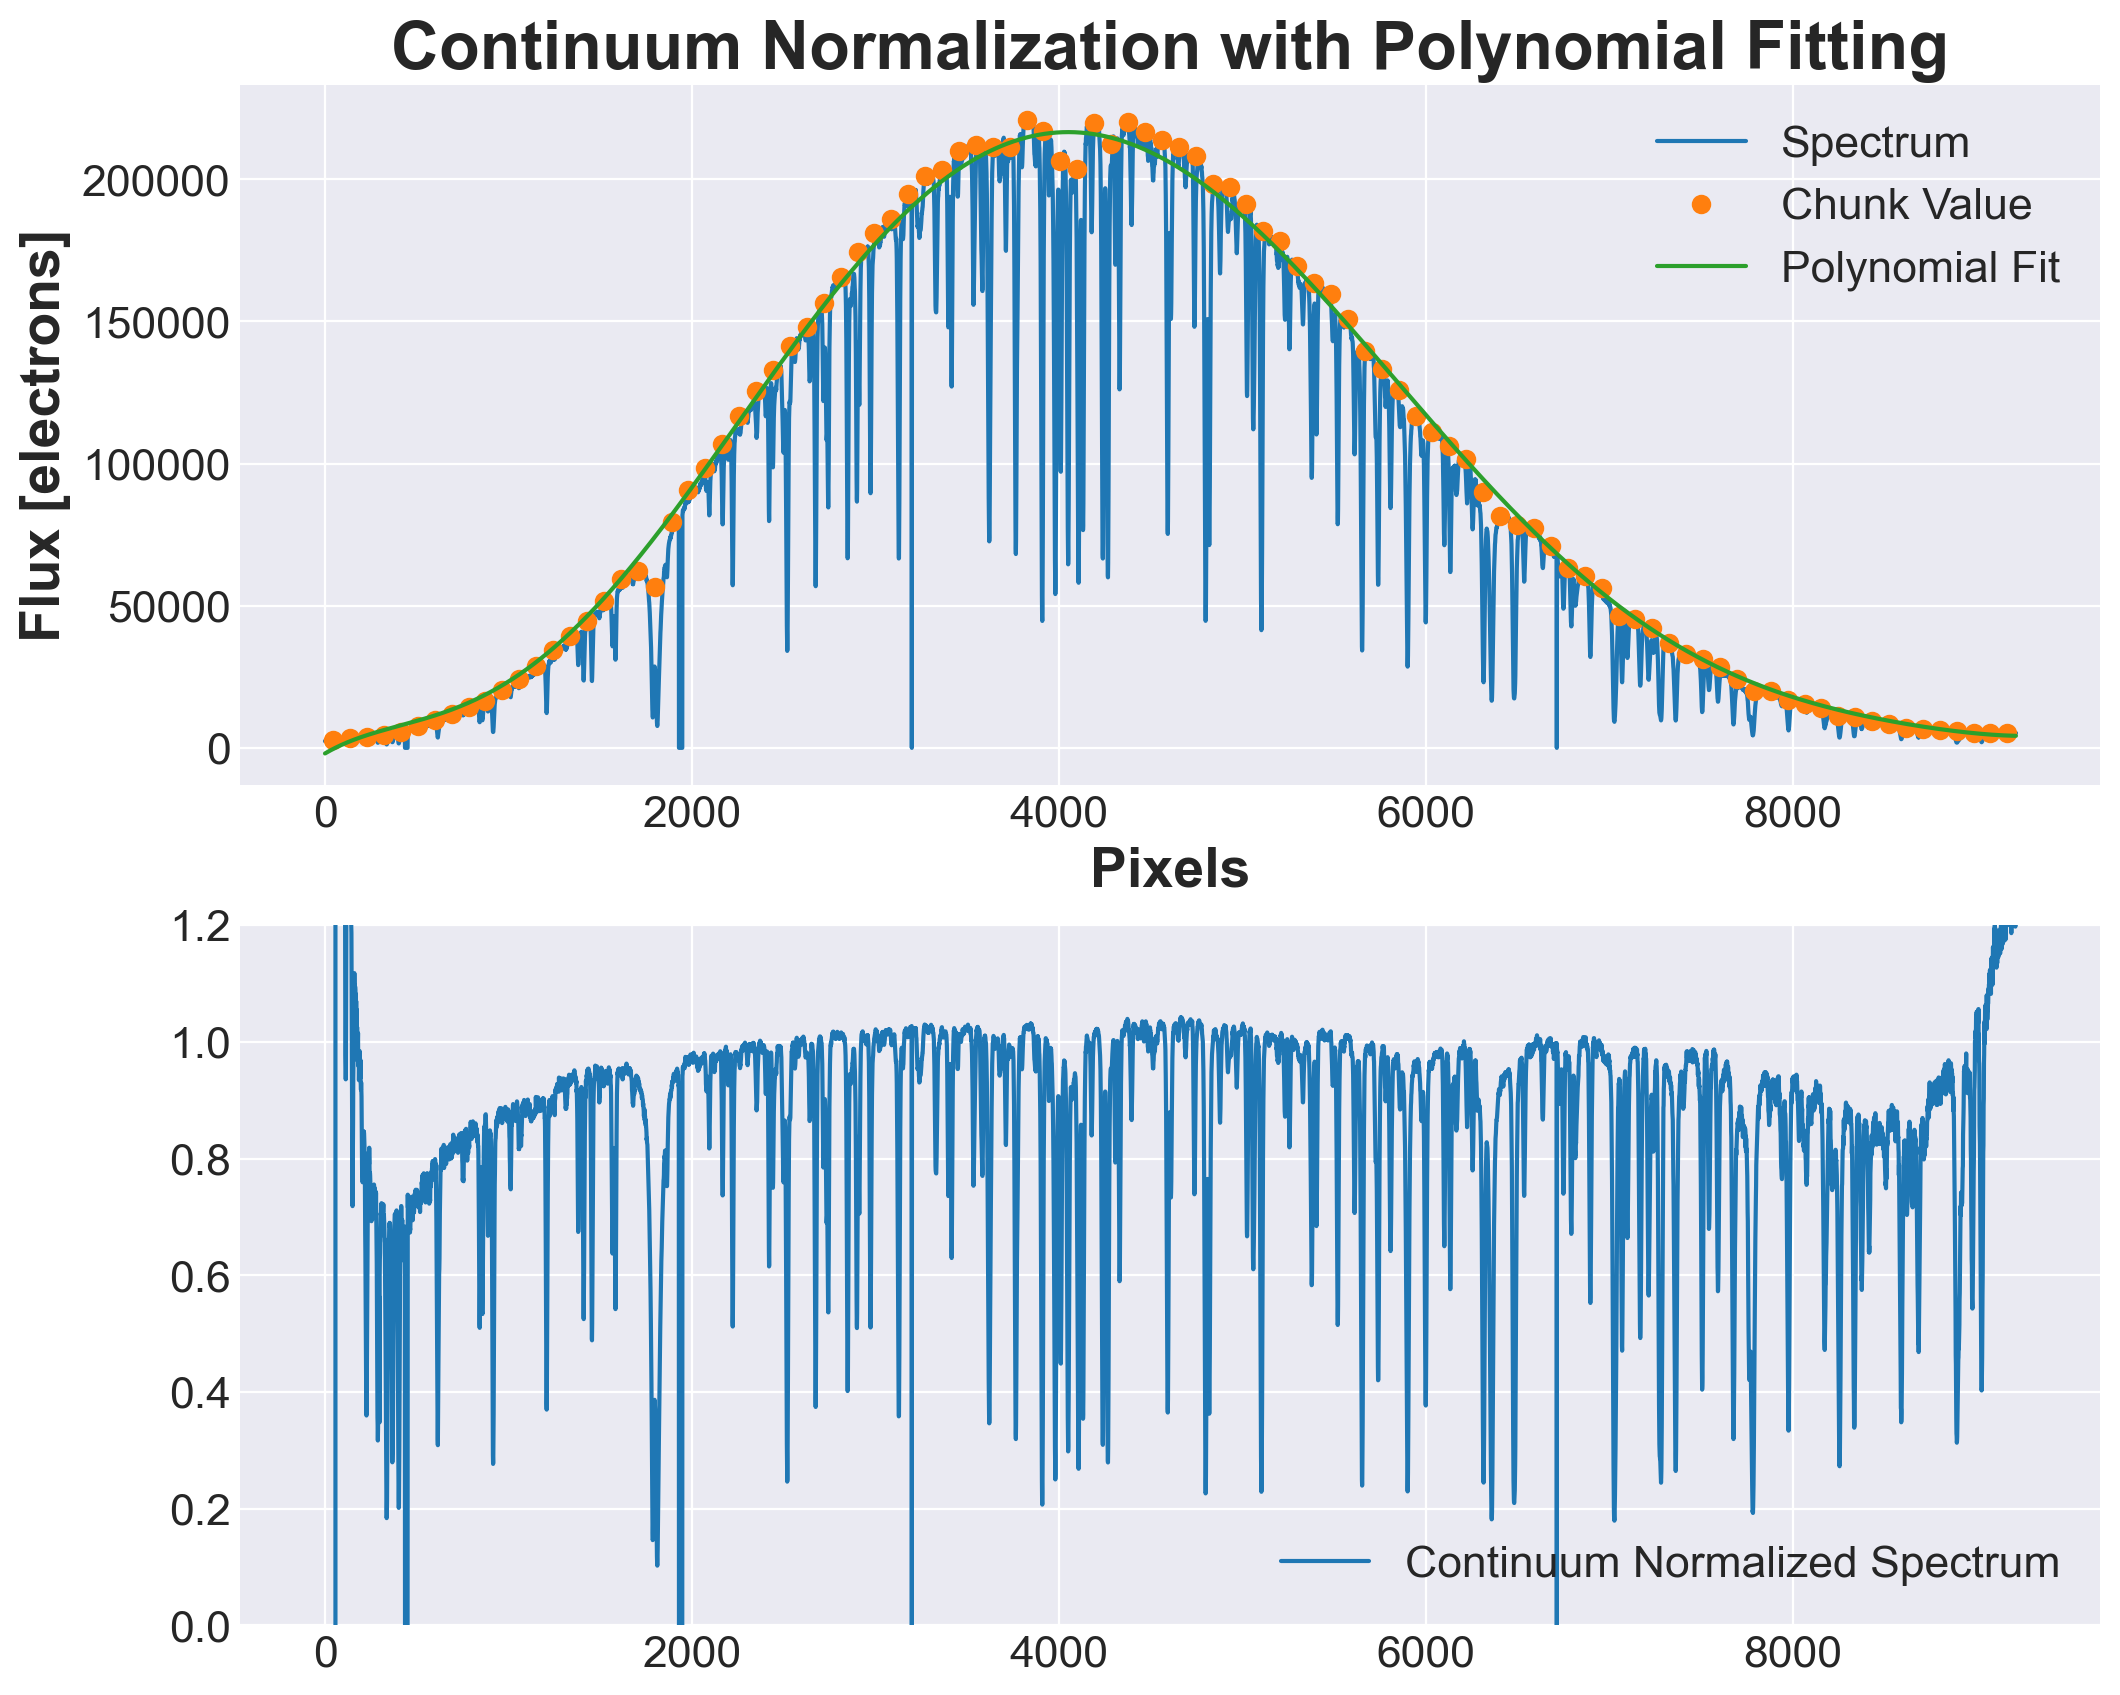

In [258]:
fig,ax = plt.subplots(nrows=2,figsize=(12,10))
ax[0].plot(flux[order,:],label='Spectrum')
ax[0].plot(chunks_x, chunks_y,'o',label='Chunk Value')
ax[0].plot(chunkfit,label='Polynomial Fit')
ax[0].set_title('Continuum Normalization with Polynomial Fitting'.format(order))
ax[0].set_xlabel('Pixels')
ax[0].set_ylabel('Flux [electrons]')
ax[0].legend()
ax[1].plot(flux[order,:]/chunkfit,label='Continuum Normalized Spectrum')
ax[1].set_ylim(0,1.2)
ax[1].legend()
plt.show()

We did decently in the middle of the order but the edges are not being fit very well. This is because we extract the NEID orders far beyond the blaze, where it is not fit represented well with a single polynomial.  

### b) Cubic Spline Fit

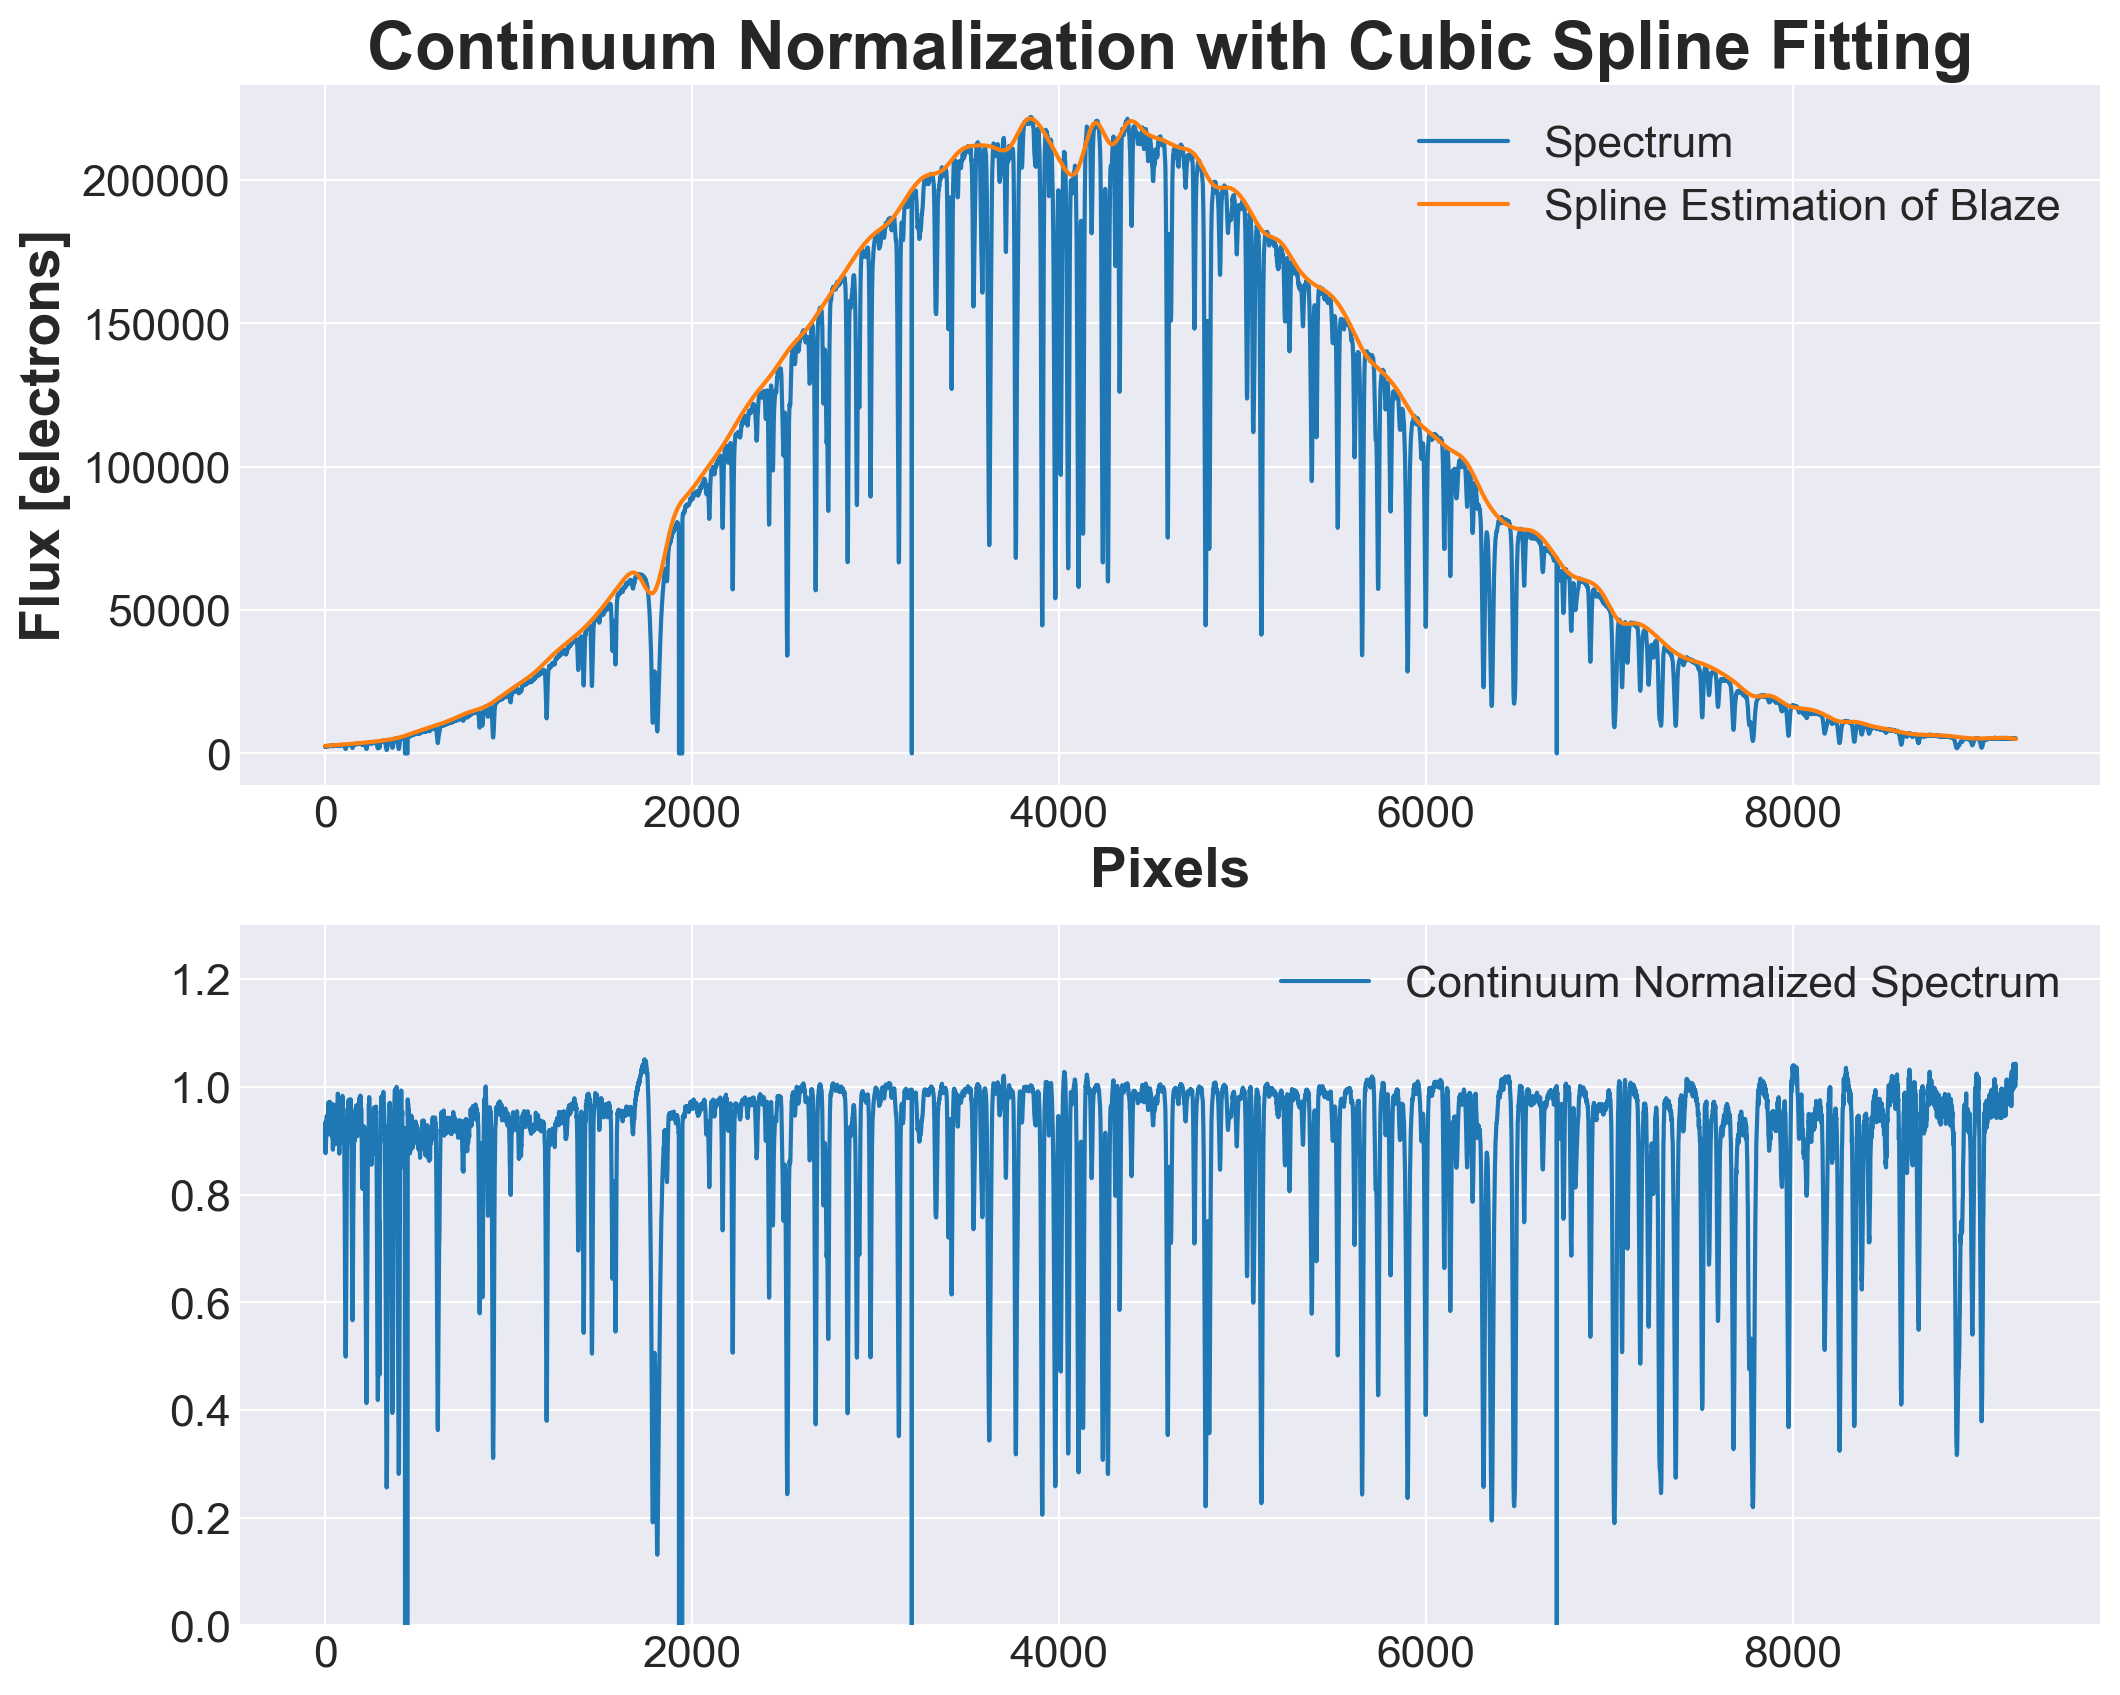

In [259]:
fig,ax = plt.subplots(nrows=2,figsize=(12,10))
ax[0].plot(flux[order,:],label='Spectrum')
ax[0].plot(cs(pix_array),label='Spline Estimation of Blaze')
ax[0].set_title('Continuum Normalization with Cubic Spline Fitting'.format(order))
ax[0].set_xlabel('Pixels')
ax[0].set_ylabel('Flux [electrons]')
ax[0].legend()
ax[1].plot(flux[order,:]/cs(pix_array),label='Continuum Normalized Spectrum')
ax[1].set_ylim(0,1.3)
ax[1].legend()
plt.show()

This looks better, but is actually not good because it fits out parts of the absorption lines. This changes their shape in a way that will affect all subsequent measurements of the lines. Splines have to be carefully controlled since they are very flexible.

### c) PyReduce
[PyReduce](https://github.com/AWehrhahn/PyReduce) is a public data reduction pipeline for echelle spectrographs. Here we will only use their continuum normalization routine. This is actually a very effective routine, but requires a good guess of the blaze function from a flat lamp spectrum. Let us say we don't have that, and try to provide an empirical guess using smoothing.

Text(0, 0.5, 'Flux [electrons]')

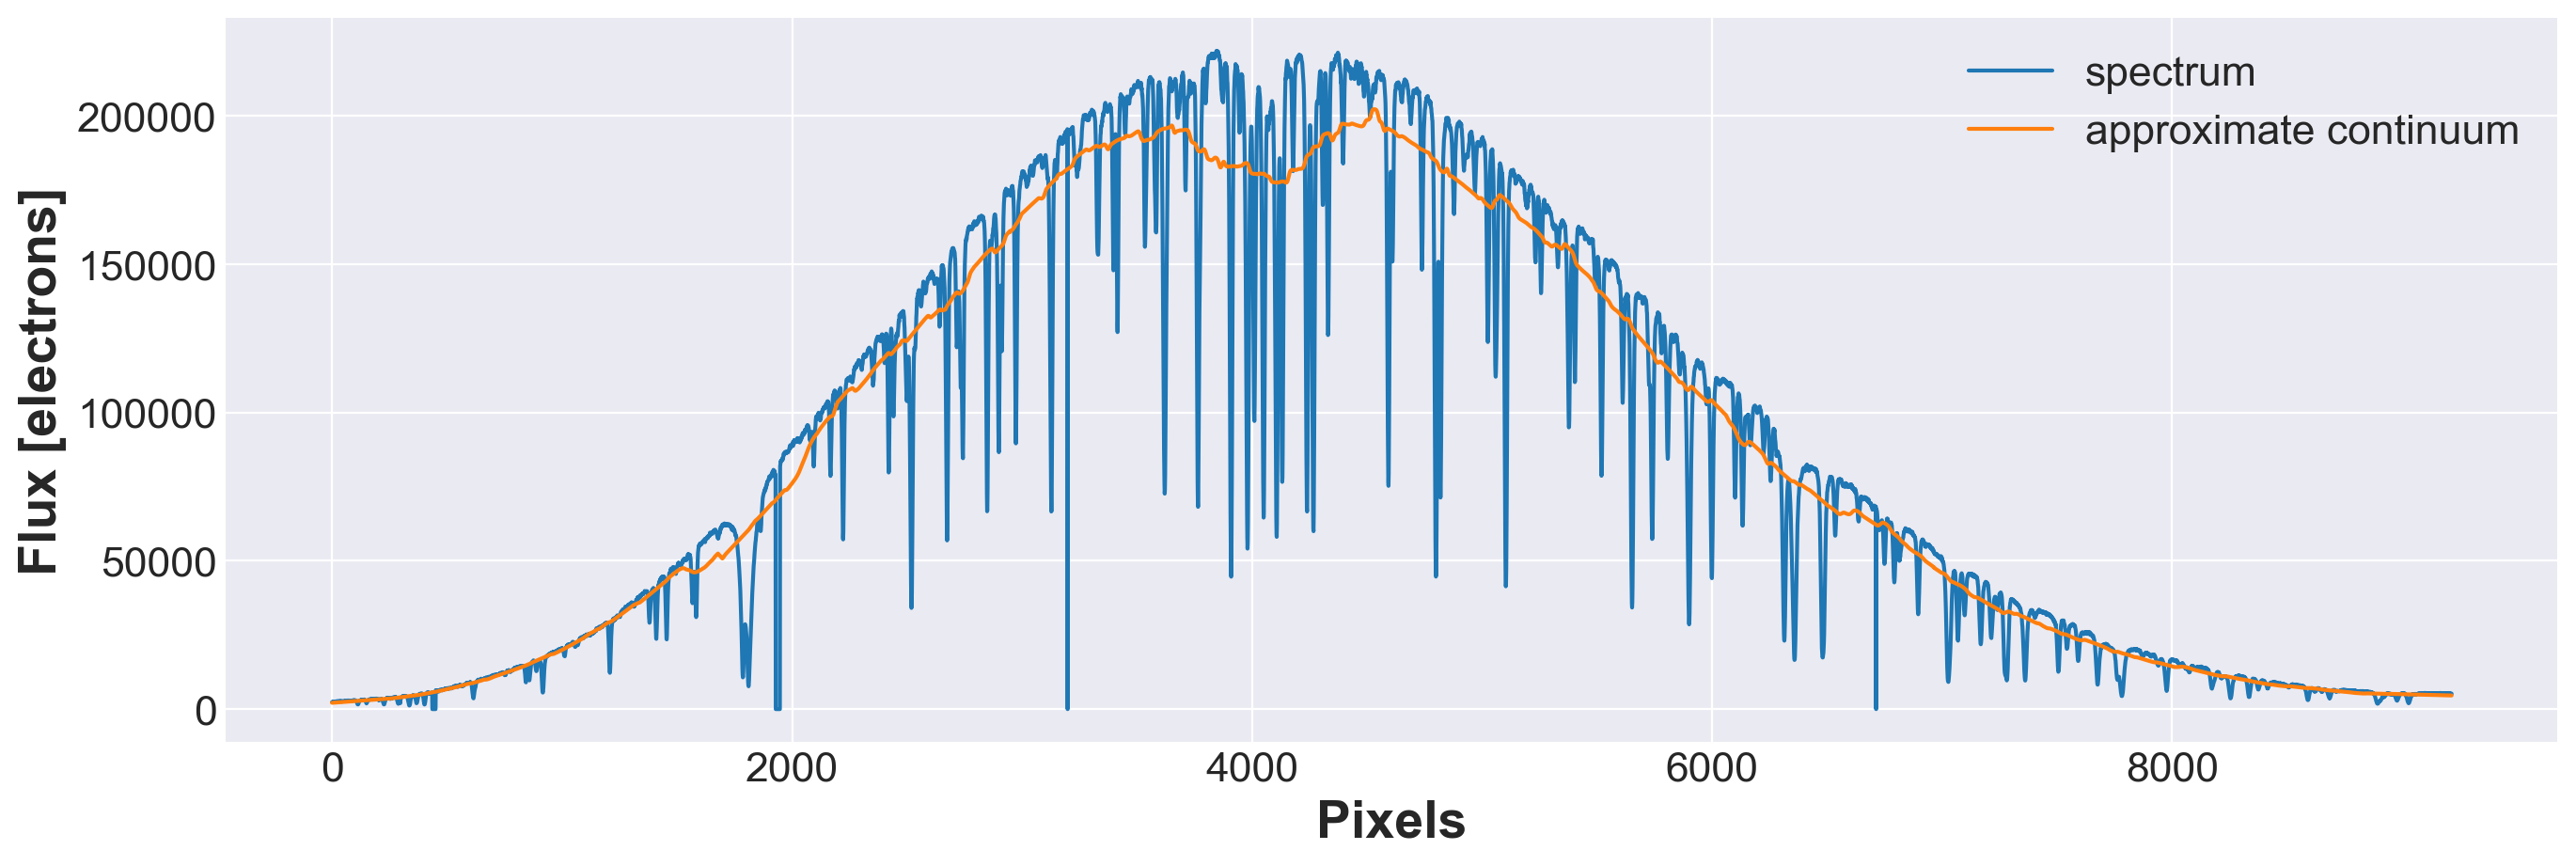

In [283]:
cont = np.ma.array(savgol_filter(flux[50:51,:], 501, 1))
plt.plot(flux[50,:],label='spectrum')
plt.plot(cont[0,:],label='approximate continuum')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Flux [electrons]')

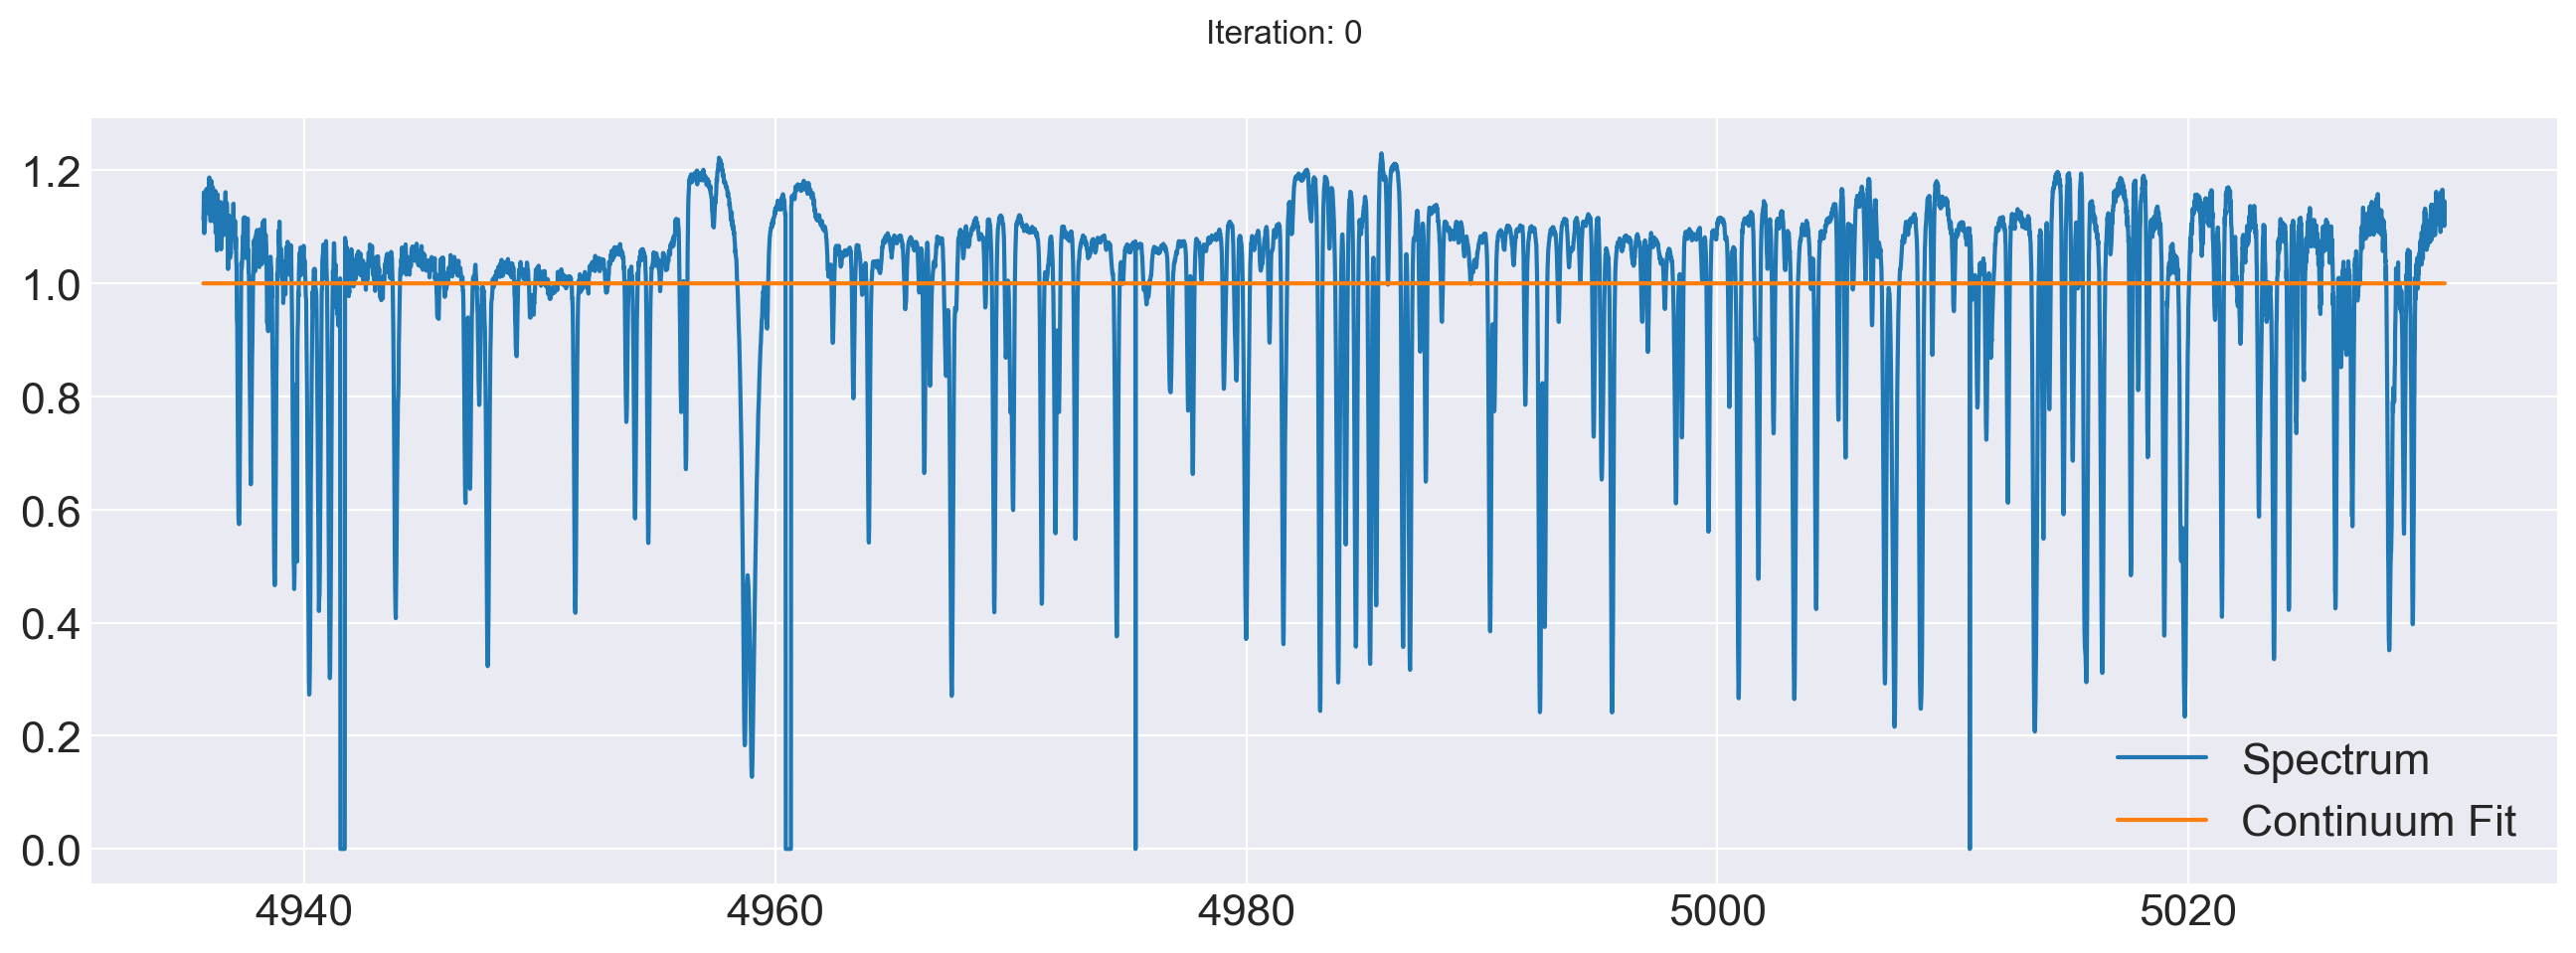

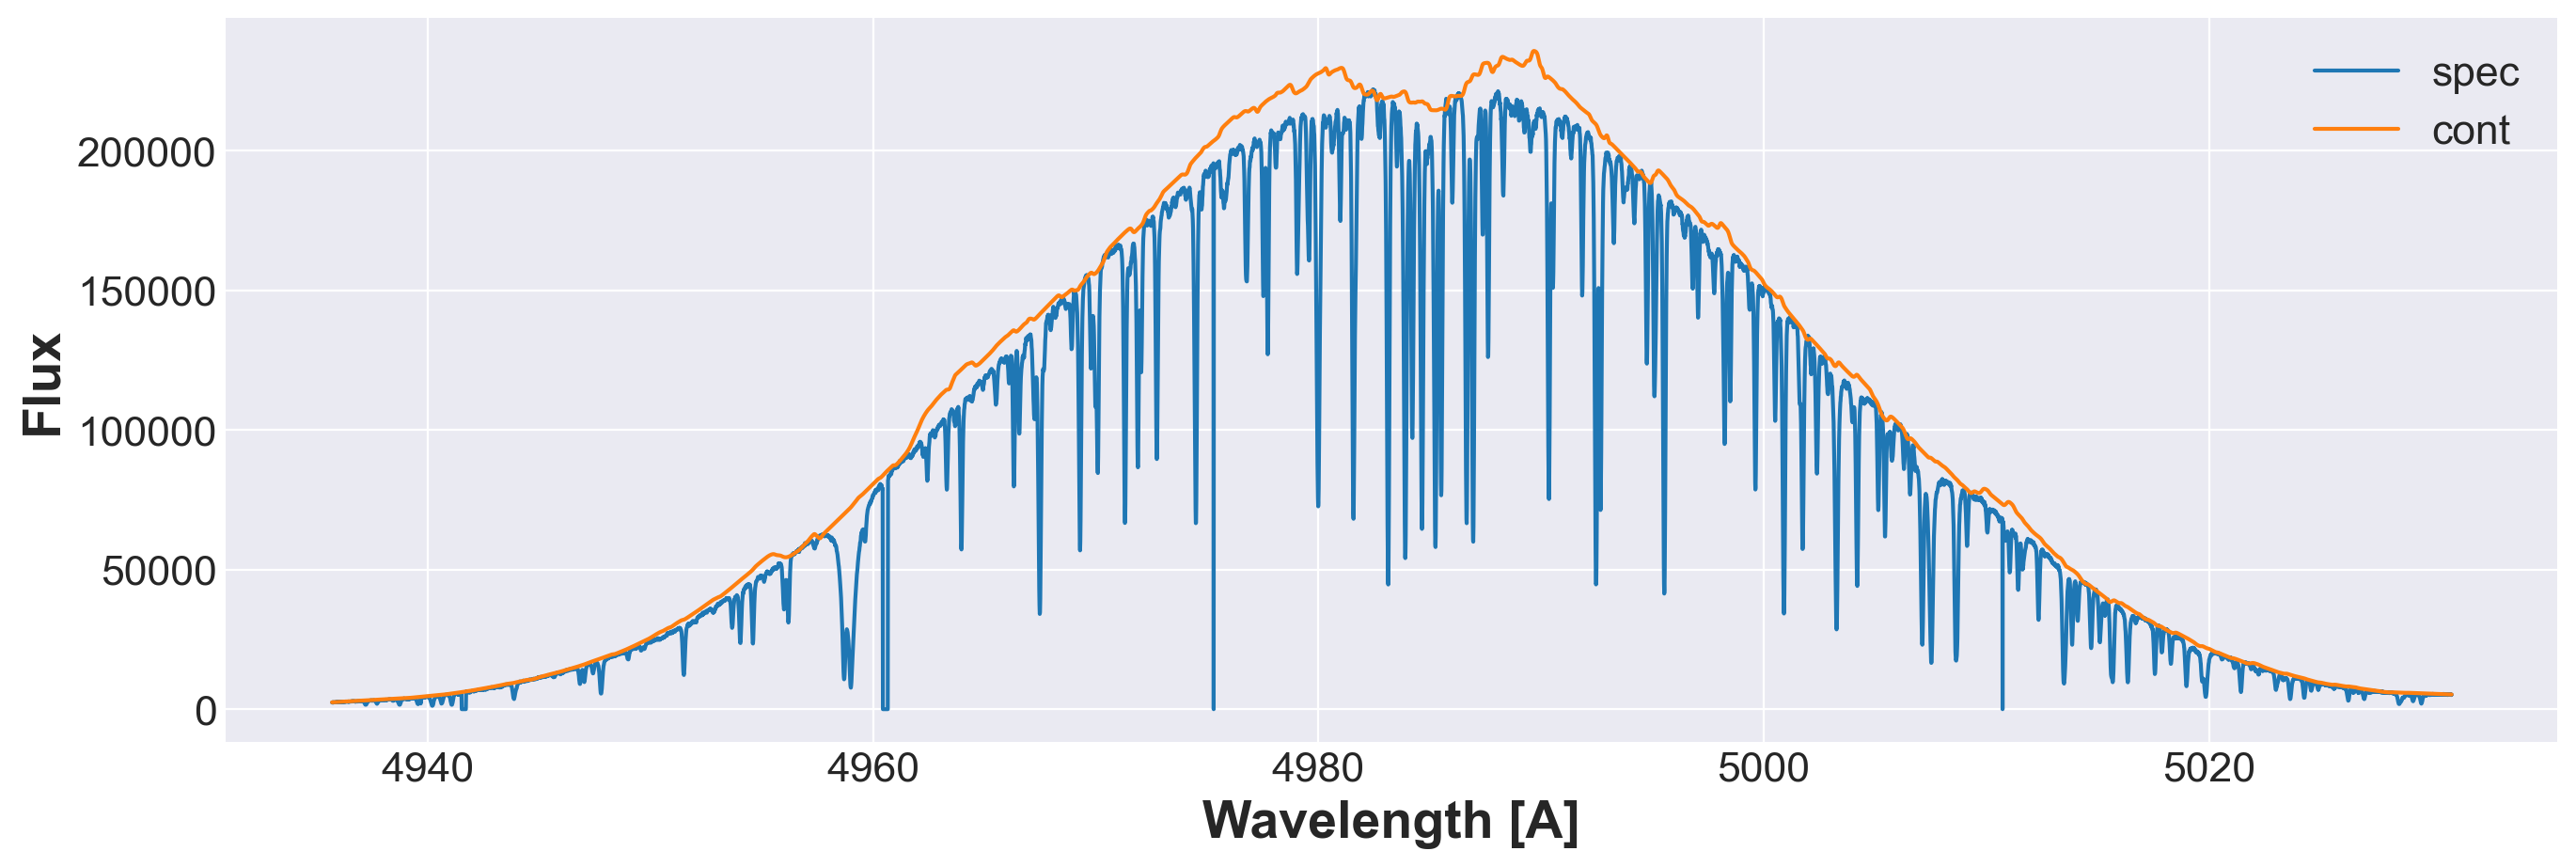

In [278]:
cont = np.ma.array(savgol_filter(flux[50:51,:], 501, 1))
sigm = np.ma.array(np.sqrt(flux[50:51,:]))
result = continuum_normalization.continuum_normalize(np.ma.array(flux[50:51,:]),np.ma.array(wave[50:51,:]),cont,sigm,plot=True)

This didn't work very well because our guess was poor. You can see the routine did it's best by moving our guess to a best fit location.

### Which one is best?

None of these continuum normalization routines are perfect, but consider which one works best for your science purposes.

Other routines to consider include [RASSINE](https://github.com/MichaelCretignier/Rassine_public), and [alpha shape fitting](https://ui.adsabs.harvard.edu/abs/2019AJ....157..243X/abstract). These can be slow, however, and not always better than simple polynomial or spline fitting.